In [1]:
import sys
if '../' not in sys.path:
    sys.path.append('../')

In [2]:
from diorep import contrast,reduceNoise
from diorep.arrman import compute_db
from diorep.arrman import get_image
from diorep.arrman import padSample
import pandas as pd
import scipy.io.wavfile as wav
import numpy as np
import IPython.display as ipd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import random
import math
import decimal
from diorep.arrplot import plotSignal
from diorep.fmanip import clip_category,gen_noise_file,get_amplitude
from diorep.arrman import lenArray
from diorep.reduceNoise import retNoiseClip,reduceNoiseNR
from diorep. fmanip import assign_probability
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import math
import librosa
from diorep.arrman import get_melspectr,random_power,mono_to_color,normalize
random.seed(123)
from diorep.arrman import get_wav_transforms
from diorep.fmanip import generate_bkgnoise
import os
from diorep.fmanip import silence_removal

C:\Users\hamhamm\anaconda3\envs\tf_gpu\lib\site-packages\noisereduce\noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
train=pd.read_csv('nlp_keywords_fade.csv')


In [4]:
train.head()

,fn,label
0,nlp_keywords_fade/IV38R7F.wav,akawuka
1,nlp_keywords_fade/KM4SKWT.wav,banana
2,nlp_keywords_fade/F5POSU9.wav,obulwadde
3,nlp_keywords_fade/MMVDXG2.wav,nnyaanya
4,nlp_keywords_fade/9TVM96F.wav,pampu


In [5]:
for i in range(len(train)):
    _,arr=wav.read(train.fn.loc[i])
    arr=arr.astype(np.float32)
    wav.write(train.fn.loc[i],22050,arr)

In [6]:
class HyperParameters():
    def __init__(self,bias=4,n_clip_length=500,audibility_threshold=50):
        """
        PARAMETERS
        ----------
        bias: Bias parameter for the Noise Threshold
        n_clip_length: Noise Clip Length
        """
        self.bias=bias
        self.sig_1p='audio_files/01RD8LR.wav'
        self.sig_2p='audio_files/0259OO7.wav'
        self.bkg_N='audio_files/SMNDURA.wav'
        self.sr=22050
        self.amp_1N=0.007746608
        self.amp_2N_ref=0.00015370044
        self.noise_threshold=compute_db(self.amp_1N,self.amp_2N_ref) + self.bias
        self.NOISE_DIR='Noise_clip_nlp'
        self.n_clip_length=n_clip_length
        self.audibility_threshold=audibility_threshold
        self.bkg_N_path='bkg_Noise_nlp'


class HyperParamsTransform():
    """
    Class to define the Hyper-parameters
    """
    def __init__(self,n_mels,img_width,padSamplePath='padSampleDir_fade',sig_len_max=60858):
        """
        PARAMETERS
        ----------
        n_mels: n_mels
        hop_length: hop_length
        INIT
        ----
        img_width
        n_mels
        hop_length
        padSamplePath: path to save padded input
        """
        self.n_mels=n_mels
        self.img_width=img_width 
        self.sig_len_max=sig_len_max
        self.hop_length= int(math.ceil(self.sig_len_max/self.img_width))
        self.sr=22050
        self.div_coef=100
        self.padSamplePath=padSamplePath
        

In [7]:
hp=HyperParameters(bias=60)
hpT=HyperParamsTransform(224,445)

In [8]:
# print the noise Threshold
print(f"The Noise Threshold in Decibel is: {hp.noise_threshold} dB ")

The Noise Threshold in Decibel is: 94 dB 


# Generating features

In [9]:
train['Sample_Length']=train.fn.transform(lambda x: lenArray(x) )

# Generating the Noise File

In [10]:
train['Noise_fn']=train.fn.transform(lambda x: gen_noise_file(x,hp.NOISE_DIR,hp.n_clip_length))

# Generating amplitude of the Noise Signal

In [11]:
train['Noise_Amplitude']=train.Noise_fn.transform(lambda x: get_amplitude(x))

# Determining noise file in decibel

In [12]:
train['dB_Noise_SPL']=train.Noise_Amplitude.transform(lambda x: compute_db(x,hp.amp_2N_ref))

In [13]:
train['dB_Noise_SPL'].max()

66

In [14]:
train['dB_Noise_SPL'].min()

-63

# Determining the Clip Group

In [15]:
train['Clip_Group']=train.dB_Noise_SPL.transform(lambda x: clip_category(x,hp.noise_threshold,mid=126))

# Assigning probability Levels to each Group

In [16]:
train['Prob_Accuracy']=train.Clip_Group.transform(lambda x: assign_probability(x))

In [17]:
train.Sample_Length.max()

60858

In [18]:
train[(train.dB_Noise_SPL < 166) &(train.dB_Noise_SPL > 76)]

,fn,label,Sample_Length,Noise_fn,Noise_Amplitude,dB_Noise_SPL,Clip_Group,Prob_Accuracy


# Determining the decibel of the Audio File


In [19]:
# Get the Audio Amplitude
train['Audio_amplitude']=train.fn.transform(lambda x: get_amplitude(x,100))
train['dB_Audio_SPL']=train.Audio_amplitude.transform(lambda x: compute_db(x,hp.amp_2N_ref))

In [20]:
train.head()

,fn,label,Sample_Length,Noise_fn,Noise_Amplitude,dB_Noise_SPL,Clip_Group,Prob_Accuracy,Audio_amplitude,dB_Audio_SPL
0,nlp_keywords_fade/IV38R7F.wav,akawuka,54243,Noise_clip_nlp/IV38R7F.wav,0.000324,6,best,1,0.721681,73
1,nlp_keywords_fade/KM4SKWT.wav,banana,55261,Noise_clip_nlp/KM4SKWT.wav,0.101424,56,best,1,0.701804,73
2,nlp_keywords_fade/F5POSU9.wav,obulwadde,55069,Noise_clip_nlp/F5POSU9.wav,0.242045,63,best,1,0.995098,76
3,nlp_keywords_fade/MMVDXG2.wav,nnyaanya,54243,Noise_clip_nlp/MMVDXG2.wav,0.001786,21,best,1,0.442655,69
4,nlp_keywords_fade/9TVM96F.wav,pampu,55566,Noise_clip_nlp/9TVM96F.wav,0.173826,61,best,1,0.710329,73


# PadSample

In [21]:
from diorep.arrman import padSample

In [22]:
def pad(train,hpT):
    dir_p=[]
    if not os.path.exists(hpT.padSamplePath):
        os.makedirs(hpT.padSamplePath)
    for i in range(len(train)):
        _=padSample(train.Sample_Length.loc[i],train.Sample_Length.max(),train.fn.loc[i]) 
        fname=train.fn.loc[i].split('/')
        fname=fname[1]
        fname=hpT.padSamplePath + '/' + fname
        dir_p.append(fname)

        wav.write(fname,hp.sr,_)
    return np.array(dir_p)
    

In [23]:
train['fn']=pad(train,hpT)

In [24]:
train['Sample_Length']=train.fn.transform(lambda x: lenArray(x) )

# Generating Background Noise

from diorep.fmanip import random_key_gen


if not os.path.exists(hp.bkg_N_path):
    os.makedirs(hp.bkg_N_path)
for i in range(len(train)):
    noise=generate_bkgnoise(train,signal_length=55566,lower_dB_threshold=66,higher_dB_threshold=166)
    key=random_key_gen(7) + '.wav'
    wav.write(os.path.join(hp.bkg_N_path,key),hp.sr,noise)
    

In [25]:
train.Sample_Length.max()

60858

# Generating MelSpectrogram

In [26]:
from diorep.arrman import mono_to_color,get_image,get_melspectr,normalize
import librosa.display
from diorep.saug import pitchShift,shiftTime,timeStretch
from diorep.reduceNoise import reduceNoiseNR
from diorep.arrman import get_wav_transforms

# pitchShift

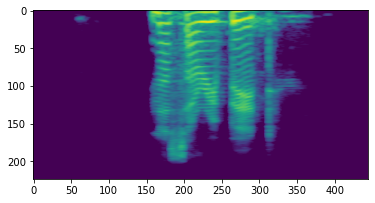

In [27]:
image_Path='latest_keywords_fade_mel'
#n_steps=-6
mel_=[]    
#transform=get_wav_transforms(noise_path)

if not os.path.exists(image_Path):
    os.makedirs(image_Path)
for i in range(len(train)):
    _,arr=wav.read(train.fn.loc[i])
    #a=reduceNoiseNR(hp.sr,arr,500)
    #a=pitchShift(a,n_steps=n_steps)
    #a=transform(a,hp.sr)
    a=get_image(arr,hpT)
    a=mono_to_color(a)
    a=normalize(a)
    img=plt.imshow(a[0])
    fname=train.fn.loc[i].split('/')
    fname=fname[1]
    fname=fname.split('.')
    fname=fname[0]
    fname=image_Path + '/' + fname + '.png'
    mel_.append(fname)
    plt.savefig(fname)